In [27]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
%autoreload 2

import os
import sys
import json
import pickle

from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution, filter_sort_index, gaussian, tie_kept_rank, orthogonalize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kurtosis, skew

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sys.path.append("../")

from src.eda import plot_feature_dist

In [29]:
class cfg:
    dataset_path = "../dataset/v5.0"
    feature_set = "small"

In [30]:
with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set]
print(f"feature col length: {len(feature_set)}") 

feature col length: 42


In [31]:

valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era", "target"] + feature_set
)

In [32]:
display(valid.head())

,era,target,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,...,feature_tridactyl_immoral_snorting,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,0.75,0,2,1,2,2,1,1,2,...,1,2,3,0,2,2,1,3,2,0
n001e1318d5072ac,0575,0.00,1,1,3,2,1,3,3,4,...,2,4,3,2,2,3,1,1,0,1
n002a9c5ab785cbb,0575,0.50,1,4,3,2,4,2,1,0,...,1,0,1,4,0,4,1,1,1,0
n002ccf6d0e8c5ad,0575,0.00,0,1,0,3,3,0,0,3,...,4,0,0,0,0,0,4,3,4,0
n0041544c345c91d,0575,0.50,0,3,4,2,2,3,1,2,...,4,3,2,2,3,2,2,0,2,1


In [16]:
valid["pred"] = 0.5
valid = valid[["era", "pred", "target"]]
print(valid.shape)

(3553377, 3)


In [17]:
benchmark_models_path = os.path.join(cfg.dataset_path, "validation_benchmark_models.parquet")
bmc = pd.read_parquet(benchmark_models_path, columns=["era", "v5_lgbm_cyrusd20"])
# bmc["v5_lgbm_cyrusd20"] = bmc["v5_lgbm_cyrusd20"].astype(np.float32)

print(bmc.shape)
display(bmc.head(2))
print(bmc.info())

(3553377, 2)


,era,v5_lgbm_cyrusd20
id,,
n000101811a8a843,0575,0.323319
n001e1318d5072ac,0575,0.860873


<class 'pandas.core.frame.DataFrame'>
Index: 3553377 entries, n000101811a8a843 to nffe574fe387a9fa
Data columns (total 2 columns):
 #   Column            Dtype  
---  ------            -----  
 0   era               object 
 1   v5_lgbm_cyrusd20  float64
dtypes: float64(1), object(1)
memory usage: 81.3+ MB
None


In [18]:

meta_model_path = os.path.join(cfg.dataset_path, "meta_model.parquet")
meta_model = pd.read_parquet(meta_model_path)
print(meta_model.shape)
print(meta_model.info())

display(meta_model.head())

(75642, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 75642 entries, n0001a161ef7f066 to nfff44a8df4e845c
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   era                 75642 non-null  object 
 1   data_type           75642 non-null  object 
 2   numerai_meta_model  75642 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.3+ MB
None


,era,data_type,numerai_meta_model
id,,,
n0001a161ef7f066,1133,validation,0.598030
n000683e569f9b8b,1133,validation,0.760381
n000df72d86f2b54,1133,validation,0.851571
n002303a67dd341c,1133,validation,0.748982
n00251ccb477cbb1,1133,validation,0.833659


In [20]:
benchmark_models_path = os.path.join(cfg.dataset_path, "validation_benchmark_models.parquet")
bmc = pd.read_parquet(benchmark_models_path, columns=["era", "v5_lgbm_cyrusd20"])
bmc["v5_lgbm_cyrusd20"] = bmc["v5_lgbm_cyrusd20"].astype(np.float32)

print(bmc.shape)
print(bmc.info())

meta_model_path = os.path.join(cfg.dataset_path, "meta_model.parquet")
meta_model = pd.read_parquet(meta_model_path)
print(meta_model.shape)
print(meta_model.info())

valid = valid.reset_index().merge(
    meta_model.reset_index(),
    how="left",
    on=["era", "id"]
).merge(
    bmc.reset_index(),
    how="left",
    on=["era", "id"]
).set_index("id")

del bmc, meta_model

display(valid.head()) 

print(valid.shape)


(3553377, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 3553377 entries, n000101811a8a843 to nffe574fe387a9fa
Data columns (total 2 columns):
 #   Column            Dtype  
---  ------            -----  
 0   era               object 
 1   v5_lgbm_cyrusd20  float32
dtypes: float32(1), object(1)
memory usage: 67.8+ MB
None
(75642, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 75642 entries, n0001a161ef7f066 to nfff44a8df4e845c
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   era                 75642 non-null  object 
 1   data_type           75642 non-null  object 
 2   numerai_meta_model  75642 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.3+ MB
None


,era,pred,target,data_type,numerai_meta_model,v5_lgbm_cyrusd20
id,,,,,,
n000101811a8a843,0575,0.5,0.75,NaN,NaN,0.323319
n001e1318d5072ac,0575,0.5,0.00,NaN,NaN,0.860873
n002a9c5ab785cbb,0575,0.5,0.50,NaN,NaN,0.749285
n002ccf6d0e8c5ad,0575,0.5,0.00,NaN,NaN,0.981402
n0041544c345c91d,0575,0.5,0.50,NaN,NaN,0.862482


(3553377, 6)


In [ ]:
def contribution(
    predictions: pd.DataFrame,
    meta_model: pd.Series,
    live_targets: pd.Series,
) -> pd.Series:
    """Calculate the contributive correlation of the given predictions
    wrt the given meta model.

    Then calculate contributive correlation by:
    1. tie-kept ranking each prediction and the meta model
    2. gaussianizing each prediction and the meta model
    3. orthogonalizing each prediction wrt the meta model
    4. multiplying the orthogonalized predictions and the targets

    Arguments:
        predictions: pd.DataFrame - the predictions to evaluate
        meta_model: pd.Series - the meta model to evaluate against
        live_targets: pd.Series - the live targets to evaluate against

    Returns:
        pd.Series - the resulting contributive correlation
                    scores for each column in predictions
    """
    # filter and sort preds, mm, and targets wrt each other
    meta_model, predictions = filter_sort_index(meta_model, predictions)
    live_targets, predictions = filter_sort_index(live_targets, predictions)
    live_targets, meta_model = filter_sort_index(live_targets, meta_model)

    # rank and normalize meta model and predictions so mean=0 and std=1
    p = gaussian(tie_kept_rank(predictions)).values
    m = gaussian(tie_kept_rank(meta_model.to_frame()))[meta_model.name].values

    # orthogonalize predictions wrt meta model
    neutral_preds = orthogonalize(p, m)
    
    # center the target
    live_targets -= live_targets.mean()

    # multiply target and neutralized predictions
    # this is equivalent to covariance b/c mean = 0
    mmc = (live_targets @ neutral_preds) / len(live_targets)

    return pd.Series(mmc, index=predictions.columns)


In [26]:
contribution(valid[["pred"]], valid["v5_lgbm_cyrusd20"], valid["target"])

pred    0.0
dtype: float64

train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era", "target"] + feature_set
)


print(train.shape)
display(train.head(2))


valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era", "target"] + feature_set
)
print(valid.shape)
display(valid.head(2))

In [6]:
train["era_int"] = train["era"].astype(int)
# train.groupby("era_int")[feature].mean()
train

,era,target,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,...,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute,era_int
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,0.25,2,2,2,2,2,0,1,2,...,1,1,3,0,2,2,3,3,2,1
n003bba8a98662e4,0001,0.25,2,2,2,2,2,1,4,2,...,2,0,0,0,2,2,4,4,2,1
n003bee128c2fcfc,0001,0.75,2,2,2,2,2,2,2,2,...,1,1,0,1,2,2,0,3,2,1
n0048ac83aff7194,0001,0.25,2,2,2,2,2,1,4,2,...,3,4,1,2,2,2,2,0,2,1
n0055a2401ba6480,0001,0.25,2,2,2,2,2,0,0,2,...,0,1,0,0,2,2,1,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffcc1dbdf2212e6,0574,0.75,1,3,0,0,0,4,3,1,...,3,4,2,4,3,2,3,3,3,574
nffde3b371d67394,0574,0.25,2,3,4,4,2,2,4,2,...,4,4,3,4,2,1,4,4,2,574
nfff1a1111b35e84,0574,0.50,0,0,2,1,4,0,0,4,...,0,0,0,0,4,4,0,0,2,574


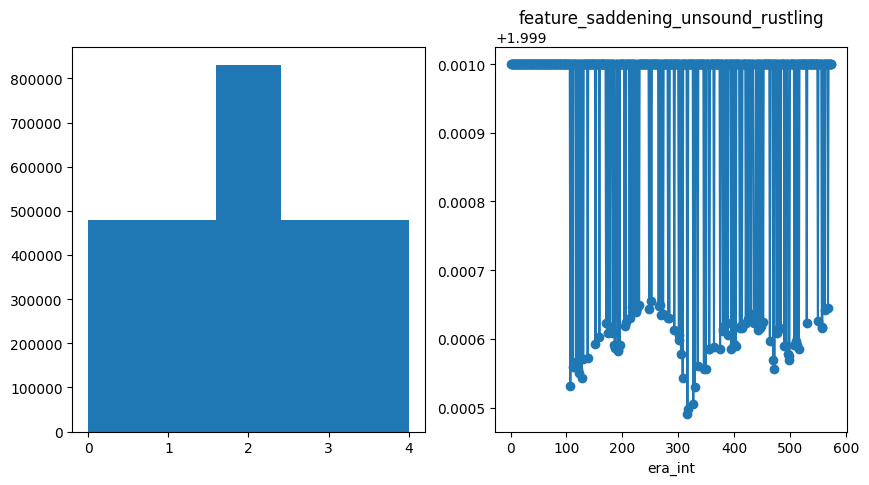

In [7]:
# 特徴量の分布をみてみる
 
feature = feature_set[0]
feature = "feature_saddening_unsound_rustling"
plot_feature_dist(train, feature)

In [8]:
scaler = StandardScaler()
feature_data_scaled = scaler.fit_transform(train[feature_set])

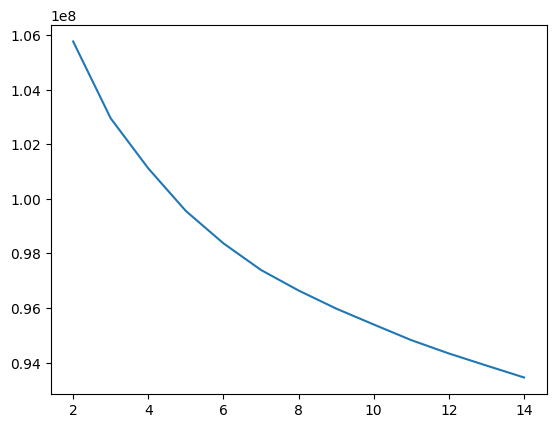

In [9]:
inertia = []
silhouette_scores = []
k_range = range(2, 15) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(feature_data_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia)
plt.show()

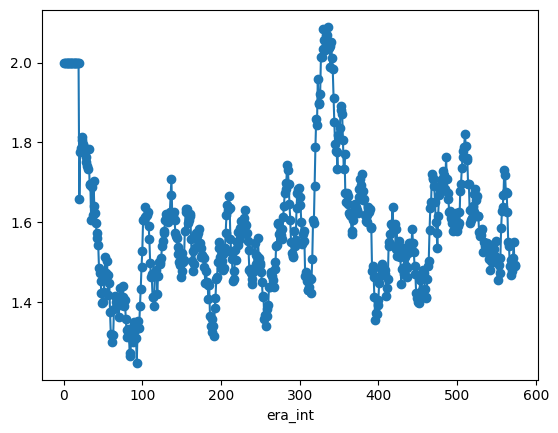

In [10]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(feature_data_scaled)
    
train["cluster"] = clusters

cond = train["cluster"] == 1

feature = feature_set[0]
train[cond].groupby("era_int")[feature].mean().plot(kind="line", marker="o")
plt.show()

In [11]:
train[feature_set].mean(axis=0)

feature_antistrophic_striate_conscriptionist     1.999918
feature_bicameral_showery_wallaba                1.999949
feature_bridal_fingered_pensioner                1.999928
feature_collectivist_flaxen_gueux                1.999924
feature_concurring_fabled_adapter                1.999928
feature_crosscut_whilom_ataxy                    1.999915
feature_departmental_inimitable_sentencer        1.999915
feature_dialectal_homely_cambodia                1.999928
feature_donnard_groutier_twinkle                 1.999928
feature_elusive_vapoury_accomplice               1.999915
feature_geminate_crummiest_scourer               1.999918
feature_glandered_unimproved_peafowl             1.974275
feature_hempen_unionist_cone                     1.999918
feature_illuminated_gambrel_noria                1.999944
feature_jacobinical_symmetric_roll               1.999918
feature_jewish_stained_disembowelment            1.999915
feature_lacklustre_centroidal_schweitzer         1.999915
feature_limies

In [12]:
train[feature_set].std(axis=0)

feature_antistrophic_striate_conscriptionist     1.402036
feature_bicameral_showery_wallaba                1.096287
feature_bridal_fingered_pensioner                1.314663
feature_collectivist_flaxen_gueux                1.374101
feature_concurring_fabled_adapter                1.320678
feature_crosscut_whilom_ataxy                    1.414359
feature_departmental_inimitable_sentencer        1.414359
feature_dialectal_homely_cambodia                1.320678
feature_donnard_groutier_twinkle                 1.320678
feature_elusive_vapoury_accomplice               1.414359
feature_geminate_crummiest_scourer               1.402036
feature_glandered_unimproved_peafowl             1.436416
feature_hempen_unionist_cone                     1.402036
feature_illuminated_gambrel_noria                1.165599
feature_jacobinical_symmetric_roll               1.402036
feature_jewish_stained_disembowelment            1.414359
feature_lacklustre_centroidal_schweitzer         1.414359
feature_limies

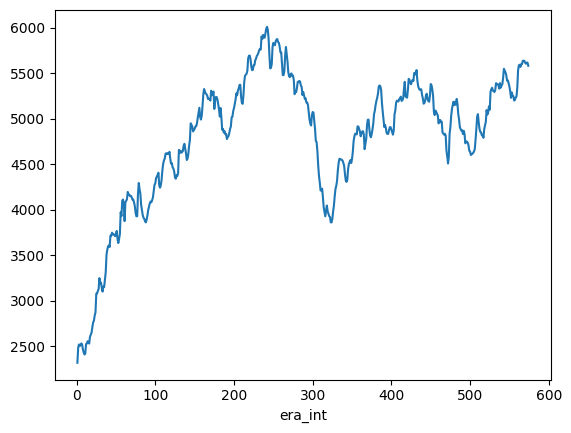

In [13]:
train.groupby("era_int")["target"].count().plot()
plt.show()

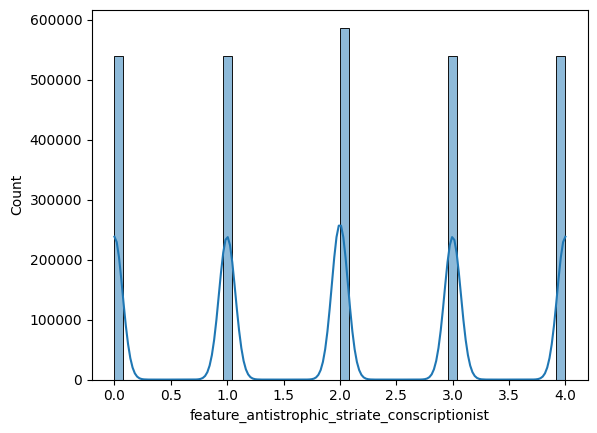

In [14]:
feature = feature_set[0]
sns.histplot(train[feature], kde=True, bins=50)
plt.show()

In [15]:
for feature in feature_set:
    skewness = skew(train[feature])
    kurt = kurtosis(train[feature])
    print(feature)
    print(f"skew: {skewness:.04f}, kurtosis: {kurt:.04f}")

feature_antistrophic_striate_conscriptionist
skew: 0.0001, kurtosis: -1.2702
feature_bicameral_showery_wallaba
skew: -0.0000, kurtosis: -0.1708
feature_bridal_fingered_pensioner
skew: 0.0000, kurtosis: -1.0327
feature_collectivist_flaxen_gueux
skew: 0.0000, kurtosis: -1.1992
feature_concurring_fabled_adapter
skew: 0.0000, kurtosis: -1.0505
feature_crosscut_whilom_ataxy
skew: 0.0001, kurtosis: -1.3002
feature_departmental_inimitable_sentencer
skew: 0.0001, kurtosis: -1.3002
feature_dialectal_homely_cambodia
skew: 0.0000, kurtosis: -1.0505
feature_donnard_groutier_twinkle
skew: 0.0000, kurtosis: -1.0505
feature_elusive_vapoury_accomplice
skew: 0.0001, kurtosis: -1.3002
feature_geminate_crummiest_scourer
skew: 0.0001, kurtosis: -1.2702
feature_glandered_unimproved_peafowl
skew: 0.0241, kurtosis: -1.3150
feature_hempen_unionist_cone
skew: 0.0001, kurtosis: -1.2702
feature_illuminated_gambrel_noria
skew: 0.0000, kurtosis: -0.4973
feature_jacobinical_symmetric_roll
skew: 0.0001, kurtosis: -1

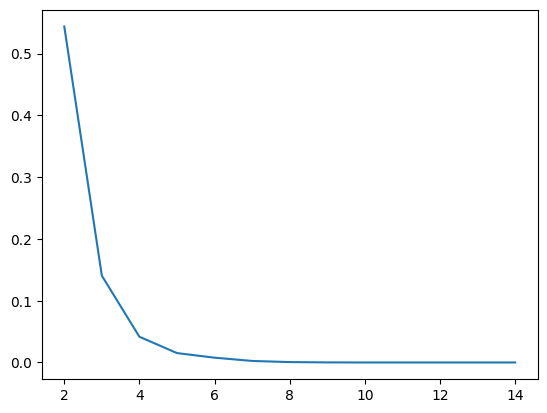

In [16]:
stats_features = []

for feature in feature_set:
    feature_data = train[feature]
    stats_features.append([
        np.mean(feature_data),
        np.std(feature_data),
        skew(feature_data),
        kurtosis(feature_data)
    ])
    
stats_features = np.array(stats_features)

inertia = []
silhouette_scores = []
k_range = range(2, 15) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(stats_features)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia)
plt.show()

In [17]:
stats_features = []

for feature in feature_set:
    feature_data = train[feature]
    stats_features.append([
        np.mean(feature_data),
        np.std(feature_data),
        skew(feature_data),
        kurtosis(feature_data)
    ])
    
stats_features = np.array(stats_features)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
cluster = kmeans.fit_predict(stats_features)


['feature_antistrophic_striate_conscriptionist', 'feature_crosscut_whilom_ataxy', 'feature_departmental_inimitable_sentencer', 'feature_elusive_vapoury_accomplice', 'feature_geminate_crummiest_scourer', 'feature_glandered_unimproved_peafowl', 'feature_hempen_unionist_cone', 'feature_jacobinical_symmetric_roll', 'feature_jewish_stained_disembowelment', 'feature_lacklustre_centroidal_schweitzer', 'feature_limiest_heliolithic_york', 'feature_mendelian_undiscording_avion', 'feature_musicianly_aspirate_creativity', 'feature_reclaimed_insurrectional_moneyer', 'feature_simulated_nonclassified_intercessor', 'feature_snakiest_somalian_wavelet', 'feature_splanchnic_notional_pint', 'feature_stretchy_spiniest_fizgig', 'feature_toltec_korean_disfavourer', 'feature_transisthmian_yogic_linden', 'feature_tridactyl_immoral_snorting', 'feature_trimeter_soggy_greatest', 'feature_unanalyzable_excusable_whirlwind', 'feature_unbreakable_constraining_hegelianism', 'feature_unformed_bent_smatch', 'feature_uns

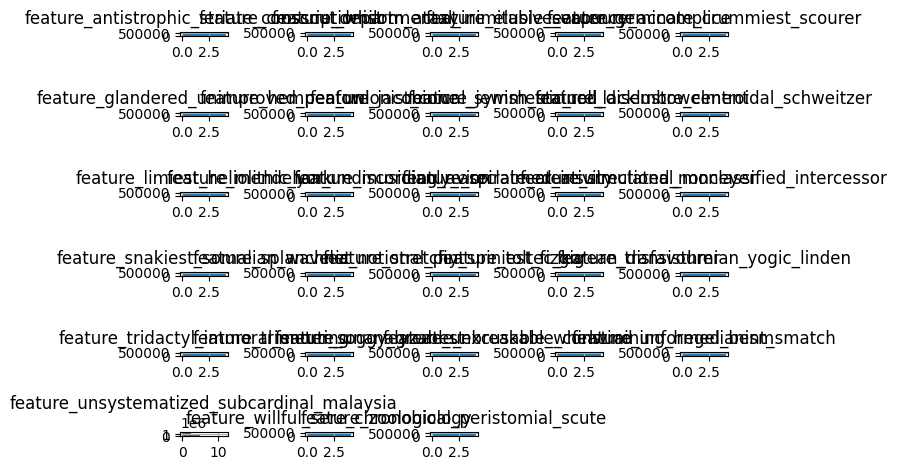

['feature_illuminated_gambrel_noria', 'feature_petty_upraised_caddice']


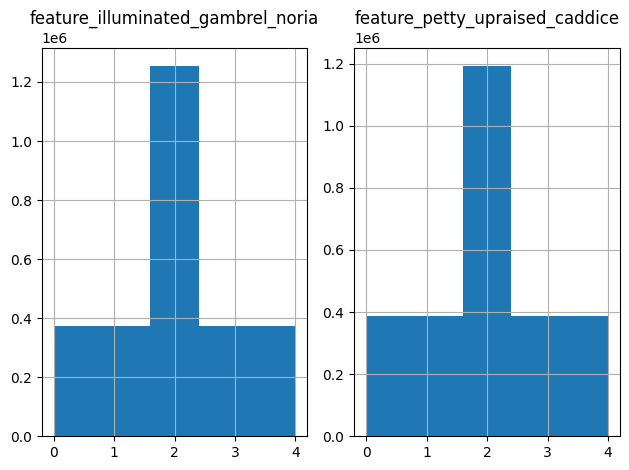

['feature_bridal_fingered_pensioner', 'feature_concurring_fabled_adapter', 'feature_dialectal_homely_cambodia', 'feature_donnard_groutier_twinkle', 'feature_maledictive_latter_psellism', 'feature_saddening_unsound_rustling', 'feature_strained_equivocal_phoneme', 'feature_unministerial_unextenuated_teleostean']


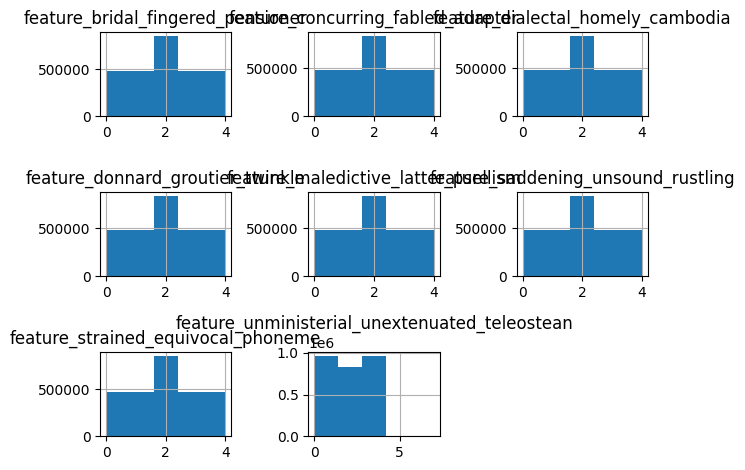

['feature_bicameral_showery_wallaba']


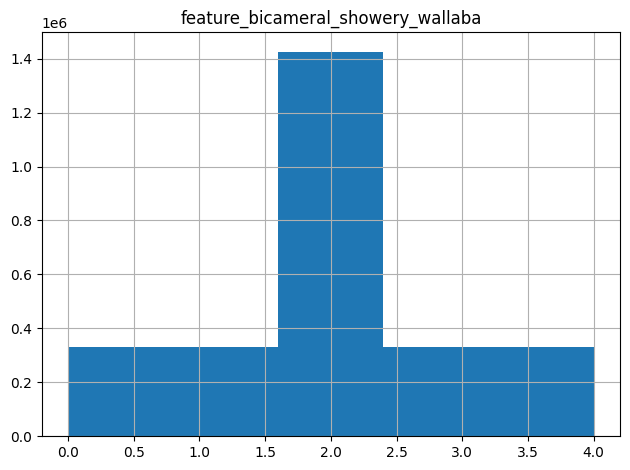

['feature_collectivist_flaxen_gueux', 'feature_pottier_unmanly_collyrium', 'feature_unmodish_zymogenic_rousing']


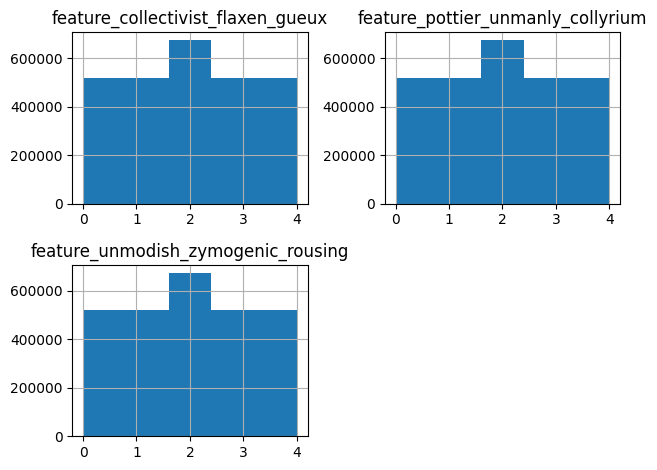

In [18]:
for i in range(n_clusters):
    cond = cluster == i
    cluster_feature = np.array(feature_set)[cond]
    
    print(list(cluster_feature))
    train[cluster_feature].hist(bins=5)
    plt.tight_layout()
    plt.show()